Dataset used in this notebook: [Amazon Alexa Reviews](https://www.kaggle.com/sid321axn/amazon-alexa-reviews)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Dropout, GlobalMaxPooling1D
from tensorflow.keras import Sequential
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_csv('/content/amazon_alexa.tsv', sep='\t')
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [ ]:
import re
def get_clean_text(x):
    x = re.sub(r'([a-zA-Z0-9+._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)', '', x) 
    #regex to remove to emails(above)
    x = re.sub(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '', x)
    #regex to remove URLs
    x = re.sub('RT', "", x)
    #substitute the 'RT' retweet tags with empty spaces
    x = re.sub('[^A-Z a-z]+', '', x)
    return x
data['verified_reviews'] = data['verified_reviews'].apply(lambda x: get_clean_text(x))

Plot how much each label class occurs in rating

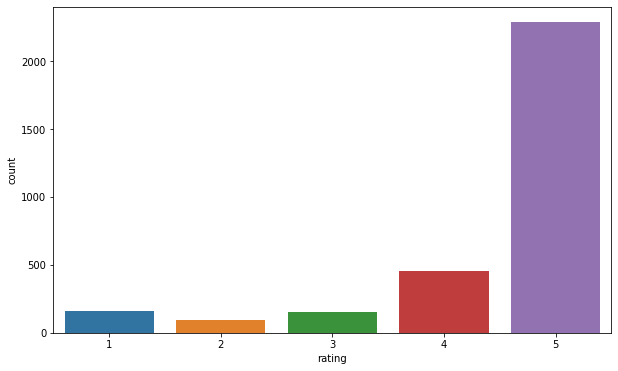

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(x=data['rating'])

In [ ]:
print("Max review length: ",data['verified_reviews'].map(len).max())
print("Min review length: ",data['verified_reviews'].map(len).min())
print("Average tweet length: ", data['verified_reviews'].map(len).mean())

chars = sorted(list(set(data['verified_reviews'])))

Max review length:  2672
Min review length:  0
Average tweet length:  127.56285714285714


In [ ]:
X = data.verified_reviews
y = data.rating.map({1:0, 2:1, 3:2, 4:3, 5:4})

train_size = int(len(data) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

Download pre-trained GloVe embeddings (a 822M zip file)
The downloaded zip contains different vectors of various sizes. We decide to use 100D (dimensions) one.


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2020-10-15 10:13:51--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-10-15 10:13:51--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-10-15 10:13:51--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

TextVectorization - for indexing the vocabulary in the dataset
We choose only top 20000 words, and we pad them to 150 tokens

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=150)
text_ds = tf.data.Dataset.from_tensor_slices(X_train).batch(128)
vectorizer.adapt(text_ds)

In [ ]:
#We can retrieve the computed vocabulary like this:
#Let's print the top 5 words
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'the', 'i', 'to']

In [ ]:
#Here's a dict mapping words to their indices:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [ ]:

path_to_glove_file = '/content/glove.6B.100d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
  for line in f:
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs, "f", sep=" ")
    embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


It's a simple NumPy matrix where entry at index i is the pre-trained vector for the word of index i in our vectorizer's vocabulary.

In [ ]:
num_tokens = len(voc)
embedding_dim = 100
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    #words not found in embedding index will be all-zeros
    #This includes the rpresentation for "padding" and "OOV"
    embedding_matrix[i] = embedding_vector
    hits += 1
  else:
    misses +=1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 3629 words (531 misses)


In [ ]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       ...,
       [-0.47080001, -0.57889003,  0.36338001, ..., -1.38180006,
        -1.30040002, -0.72518998],
       [ 0.0099226 , -1.01339996,  0.31173   , ...,  0.047227  ,
         0.57251   ,  0.74444997],
       [ 0.043993  , -0.56252003,  0.27654999, ..., -0.13319001,
        -0.10245   , -0.28321001]])

In [ ]:
embedding_layer = Embedding(num_tokens, embedding_dim, 
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            trainable=False)

In [ ]:
int_sequences_input = tf.keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = Conv1D(128, 5, activation="relu")(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation="relu")(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation="relu")(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
preds = Dense(5, activation="softmax")(x)
model = tf.keras.Model(int_sequences_input, preds)
model.summary()

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 100)         416000    
_________________________________________________________________
conv1d_27 (Conv1D)           (None, None, 128)         64128     
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, None, 128)         0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, None, 128)         82048     
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, None, 128)         0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, None, 128)       

First, convert our list-of-strings data to NumPy arrays of integer indices. The arrays are right-padded.

In [ ]:
x_train = vectorizer(np.array([[s] for s in X_train])).numpy()
x_test = vectorizer(np.array([[s] for s in X_test])).numpy()

y_train = np.array(y_train)
y_val = np.array(y_test)

Define a checkpoint, where we will save the current best model(based on val_acc) only.

In [ ]:
checkpoint_path = '/content/checkpoint'
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_acc',
    save_best_only=True
)

model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"]
)
model.fit(x_train, y_train, batch_size=64, epochs=20, validation_data=(x_test, y_test), callbacks=[callback])

Epoch 1/20
40/40 [==============================] - 4s 100ms/step - loss: 1.0150 - acc: 0.7091 - val_loss: 0.9390 - val_acc: 0.6905
Epoch 2/20
40/40 [==============================] - 4s 96ms/step - loss: 0.8462 - acc: 0.7341 - val_loss: 0.8990 - val_acc: 0.6905
Epoch 3/20
40/40 [==============================] - 4s 98ms/step - loss: 0.7495 - acc: 0.7353 - val_loss: 0.9466 - val_acc: 0.6905
Epoch 4/20
40/40 [==============================] - 4s 98ms/step - loss: 0.6796 - acc: 0.7409 - val_loss: 0.8815 - val_acc: 0.6937
Epoch 5/20
40/40 [==============================] - 4s 93ms/step - loss: 0.5786 - acc: 0.7635 - val_loss: 1.0280 - val_acc: 0.6921
Epoch 6/20
40/40 [==============================] - 4s 92ms/step - loss: 0.5049 - acc: 0.8008 - val_loss: 0.9877 - val_acc: 0.7063
Epoch 7/20
40/40 [==============================] - 4s 96ms/step - loss: 0.3963 - acc: 0.8437 - val_loss: 1.3173 - val_acc: 0.6905
Epoch 8/20
40/40 [==============================] - 4s 95ms/step - loss: 0.3303 - 